# Questions

- For each participant: 
    - number of messages
    - words per message
    - most used words
    - number of emojis
    - most used emojis


- Sentiment analysis:
    - group sentiment over time
    - sentiment index of each participant
    - pie chart of message sentiments
    - worst and best message and from who
    - wordcloud

Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from textblob import TextBlob
import operator
from collections import Counter
import emoji
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import asyncio
import concurrent
import re
from functools import partial
from pandas.api.types import CategoricalDtype
from datetime import datetime
from wordcloud import WordCloud
%matplotlib inline

Some details about the file.

In [2]:
data = "data/chat.txt"
language = 'portuguese'
language_code = 'pt'
table = pd.DataFrame(columns=('date', 'time', 'sender', 'message'))

Processing the file and building the dataframe:

In [3]:
with open(data) as f:
    raw_message = ""
    counter = 0
    for line in tqdm(f):
        if line.startswith('['):
            # date
            datePattern = '(\d+/\d+/\d+)' 
            try:
                date = re.search(datePattern, raw_message).group(0)
            except AttributeError:
                date = "No date"
            
            # time
            timePattern = '(\d+:\d+:\d+)'
            try:
                time = re.search(timePattern, raw_message).group(0)
            except AttributeError:
                time = "No Time"

            # sender
            personPattern = '((?<=]).+?(?=:))'
            try:
                person = re.search(personPattern, raw_message).group(0).replace("] ", "")
            except AttributeError:
                person = "No Person"
            
            # message
            messagePattern = '(:\s).*'    
            try:
                text = re.search(messagePattern, raw_message).group(0).replace(": ", "")
            except AttributeError:
                text = "No message"
            
            table.loc[counter] = [date, time, person, text]
            counter += 1
        
            raw_message = line
        else:
            raw_message += line       

13524it [00:19, 700.64it/s]


We clean the imports and print the head of the dataframe: 

In [4]:
table = table[~table.message.str.contains("omitted")]
table = table[~table.message.str.contains("No message")]
table = table[~table.message.str.contains("Messages to this group are")]
table = table[~table.date.str.contains("No date")]
table.head()

,date,time,sender,message
2,19/10/2016,00:08:02,Pai,Material de lavagem de mãos para médicos na co...
4,19/10/2016,00:21:40,Duarte OC,Wow..
5,19/10/2016,00:21:47,Duarte OC,😓
6,19/10/2016,17:25:44,Locas Oliveira E Carmo,Pai?? Onde e que ta?
7,19/10/2016,18:37:13,Duarte OC,Bem.. Este transito em Lisboa...


# Participant comparison

Text(0.5, 1.0, 'Total Messages send by each participant')

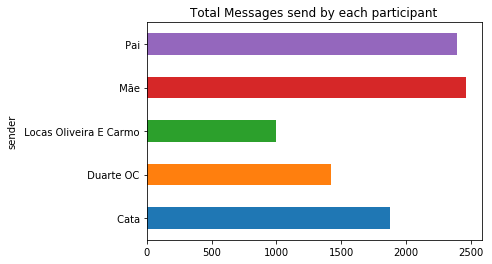

In [5]:
table.groupby('sender').message.count().plot(kind='barh')
plt.title('Total Messages send by each participant')

Text(0.5, 1.0, 'Words per message for each participant')

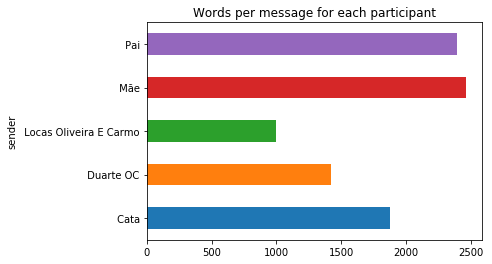

In [6]:
table['message_size'] = table.message.str.split().str.len()
table.groupby('sender').message_size.count().plot(kind='barh')
plt.title('Words per message for each participant')


Top words for  Pai:
boa with 250 uses.
ló with 137 uses.
docas with 129 uses.
catocas with 116 uses.
é with 110 uses.

Top emojis for  Pai:
❤ with 11 uses.
👍 with 9 uses.
🤙 with 5 uses.

Cloud for  Pai:


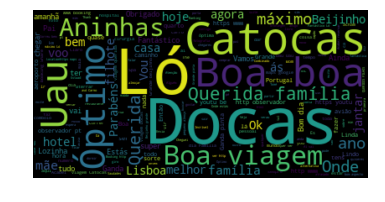

--------------------

Top words for  Mãe:
boa with 115 uses.
catocas with 98 uses.
luisinha with 96 uses.
micas with 91 uses.
é with 89 uses.

Top emojis for  Mãe:
😉 with 53 uses.
😁 with 20 uses.
😊 with 14 uses.

Cloud for  Mãe:


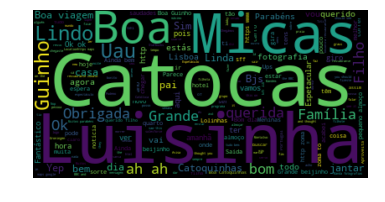

--------------------

Top words for  Duarte OC:
pai with 119 uses.
boa with 56 uses.
uau with 49 uses.
é with 48 uses.
bem with 47 uses.

Top emojis for  Duarte OC:
😊 with 6 uses.
😂 with 3 uses.
😭 with 3 uses.

Cloud for  Duarte OC:


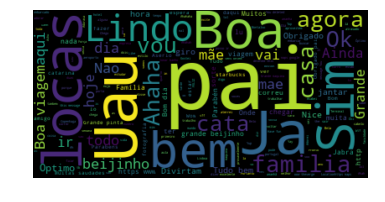

--------------------

Top words for  Locas Oliveira E Carmo:
pai with 75 uses.
nao with 44 uses.
boa with 41 uses.
obrigada with 27 uses.
mae with 26 uses.

Top emojis for  Locas Oliveira E Carmo:
❤ with 13 uses.
😇 with 3 uses.
😀 with 2 uses.

Cloud for  Locas Oliveira E Carmo:


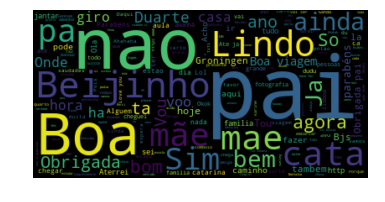

--------------------

Top words for  Cata:
boa with 112 uses.
pai with 108 uses.
é with 85 uses.
agora with 70 uses.
mãe with 69 uses.

Top emojis for  Cata:
😃 with 16 uses.
😁 with 12 uses.
👌 with 11 uses.

Cloud for  Cata:


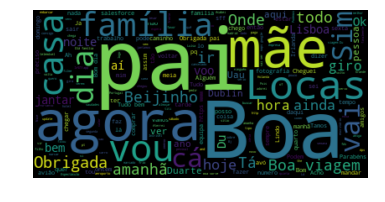

--------------------


In [7]:
senders = list(set(table.sender))
raw_text = {}

for sender in senders: 
    raw_text[sender] = ""

for idx, row in table.iterrows():
    sender = row.sender
    message = row.message
    raw_text[sender] += message + " "
    
for sender in senders:
    # clean words and extract most used
    bad_words = stopwords.words(language)
    blob = list(TextBlob(raw_text[sender]).lower().words)
    clean_blob = [word for word in blob if word not in bad_words]
    top_words = Counter(clean_blob).most_common()[0:5]
    print(f"\nTop words for {sender}:")
    for element in top_words:
        print(f"{element[0]} with {element[1]} uses.")

    # get most used emojis
    emoji_list = []
    for item in clean_blob:
        if item in emoji.UNICODE_EMOJI:
            emoji_list.append(item)
    top_emoji = Counter(emoji_list).most_common()[0:3]
    print(f"\nTop emojis for {sender}:")
    for element in top_emoji:
        print(f"{element[0]} with {element[1]} uses.")
        
    # create a cloud of words for each participant
    print(f"\nCloud for {sender}:")
    stopwords_set = set(bad_words)
    wc = WordCloud(stopwords=stopwords_set).generate(raw_text[sender])
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print('-' * 20)

# Sentiment Analysis

Text(0.5, 1.0, 'Total messages per weekday')

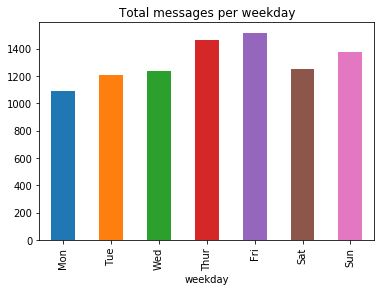

In [8]:
def convert_to_weekday(date_string):
    day_names = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
    datetime_object = datetime.strptime(date_string, '%d/%m/%Y')
    return day_names[datetime_object.weekday()]

cats = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
cat_type = CategoricalDtype(categories=cats, ordered=True)

table['weekday'] = [convert_to_weekday(element) for element in table['date']]
table.groupby('weekday').message.count().reindex(cats).plot(kind='bar')
plt.title('Total messages per weekday')

Text(0.5, 1.0, 'Total messages per weekday for  Locas Oliveira E Carmo')

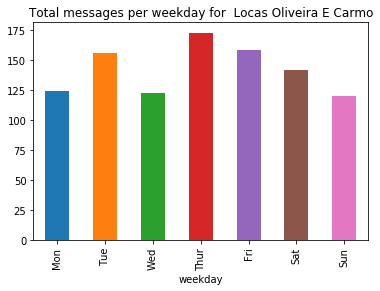

In [9]:
sender = senders[3]
a = table[(table['sender'] == sender)]
a.groupby('weekday').message.count().reindex(cats).plot(kind='bar')
plt.title(f"Total messages per weekday for {sender}")

([<matplotlib.patches.Wedge at 0x110660d30>,
 [Text(0.6597897117995603, 0.8801576768985506, 'happy'),
  Text(-0.6597897942058667, -0.8801576151245755, 'not happy')],
 [Text(0.3598852973452147, 0.48008600558102754, '29.5%'),
  Text(-0.35988534229410907, -0.480085971886132, '70.5%')])

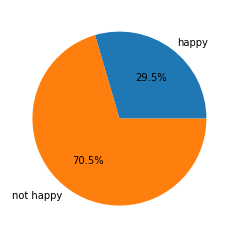

In [10]:
def happy_message(message):
    if '!' in message: 
        return True 
    else: return False

table['happy_message'] = [happy_message(message) for message in table['message']]
#table.groupby('happy_message').message.count().plot(kind='bar')
#plt.title(f"Are messages happy?")
happy_percentage = table['happy_message'].sum() / table['message'].count() * 100
sad_percentage = 100 - happy_percentage
data = [happy_percentage, sad_percentage]
labels = ['happy', 'not happy']
plt.pie(data, labels=labels, autopct='%1.1f%%')

Text(0.5, 1.0, 'Happiness Ratios')

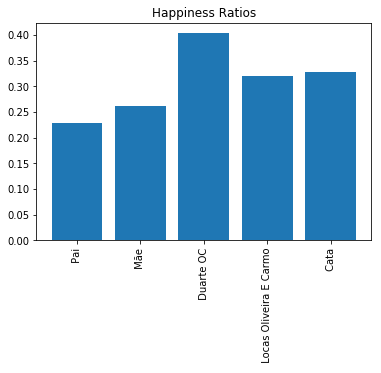

In [11]:
happyness_ratios = []
for sender in senders: 
    personal = table[(table['sender']== sender)]
    happyness_ratio = personal.happy_message.sum() / personal.message.count()
    happyness_ratios.append(happyness_ratio)

plt.bar(senders, happyness_ratios)
plt.xticks(rotation=90)
plt.title('Happiness Ratios')

In [12]:
table['date_datetime'] = pd.to_datetime(table['date'], format='%d/%m/%Y')
table['time_datetime'] = pd.to_datetime(table['time'], format='%H:%M:%S')

Text(0.5, 1.0, 'Happy messages throughout the year')

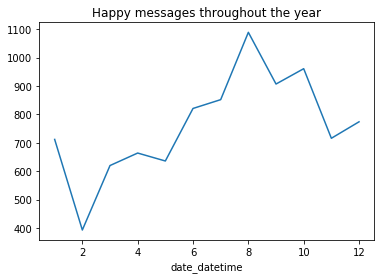

In [13]:
# I could do mean
table.groupby(table.date_datetime.dt.month).happy_message.count().plot()
plt.title('Happy messages throughout the year')

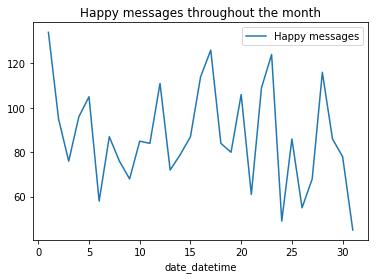

In [14]:
table.groupby(table.date_datetime.dt.day).happy_message.sum().plot(label='Happy messages')
#table.groupby(table.date_datetime.dt.day).message.count().plot(label='Total messages')
plt.title('Happy messages throughout the month')
plt.legend()

([<matplotlib.axis.XTick at 0x110cc6940>,
 <a list of 7 Text xticklabel objects>)

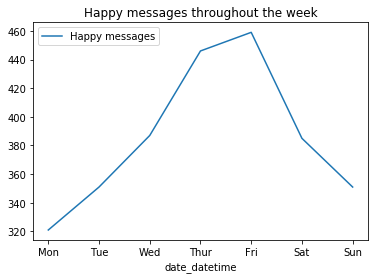

In [15]:
table.groupby(table.date_datetime.dt.dayofweek).happy_message.sum().plot(label='Happy messages')
#table.groupby(table.date_datetime.dt.dayofweek).message.count().plot(label='Total messages')
plt.title('Happy messages throughout the week')
plt.legend()
plt.xticks(range(len(cats)), cats)

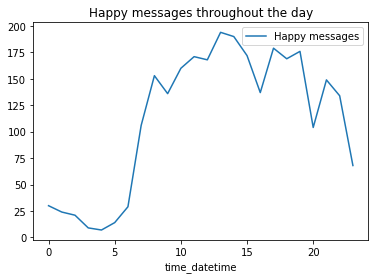

In [16]:
table.groupby(table.time_datetime.dt.hour).happy_message.sum().plot(label='Happy messages')
#table.groupby(table.time_datetime.dt.hour).message.count().plot(label='Total messages')
plt.title('Happy messages throughout the day')
plt.legend()